# CIFAR-10 Data Set 

### Load Data 

In [70]:
import torch
import torchvision
import torchvision.transforms as transforms

In [71]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Explore Data Set 

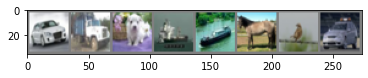

  car truck   dog  ship  ship horse  bird   car


In [72]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

## Training Phase

### CNN Model

In [76]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,2)
        self.conv3 = nn.Conv2d(32,64,3)
        self.conv4 = nn.Conv2d(64,128,3)
        self.fc1 = nn.Linear(128 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32, 10)
        self.dropout = nn.Dropout(0.2)
        
        fc1 = 1.0/np.sqrt(self.fc1.weight.data.size()[0])
        fc2 = 1.0/np.sqrt(self.fc2.weight.data.size()[0])
        fc3 = 1.0/np.sqrt(self.fc3.weight.data.size()[0])
        fc4 = 1.0/np.sqrt(self.fc4.weight.data.size()[0])
        
        T.nn.init.uniform_(self.fc1.weight.data, -fc1,fc1)
        T.nn.init.uniform_(self.fc1.bias.data, -fc1,fc1)
        T.nn.init.uniform_(self.fc2.weight.data,-fc2,fc2)
        T.nn.init.uniform_(self.fc2.bias.data, -fc2,fc2)
        T.nn.init.uniform_(self.fc3.weight.data,-fc3,fc3)
        T.nn.init.uniform_(self.fc3.bias.data, -fc3,fc3)
        T.nn.init.uniform_(self.fc4.weight.data,-fc4,fc4)
        T.nn.init.uniform_(self.fc4.bias.data, -fc4,fc4)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


net = Net()

In [77]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [78]:
net.train()
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    i=0
    for data in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        i+=1
print('Finished Training')


[1,  2000] loss: 1.945
[1,  4000] loss: 1.647
[1,  6000] loss: 1.517
[2,  2000] loss: 1.402
[2,  4000] loss: 1.343
[2,  6000] loss: 1.303
[3,  2000] loss: 1.225
[3,  4000] loss: 1.182
[3,  6000] loss: 1.186
[4,  2000] loss: 1.099
[4,  4000] loss: 1.095
[4,  6000] loss: 1.086
[5,  2000] loss: 1.018
[5,  4000] loss: 1.021
[5,  6000] loss: 1.026
Finished Training


#### Save Model

In [79]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Predict Test Data

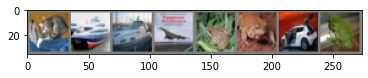

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog


In [80]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [81]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [82]:
outputs = net(images)

In [83]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

Predicted:    cat  ship  ship plane  frog  frog   car  frog


In [84]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


In [85]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 73 %
Accuracy of   car : 82 %
Accuracy of  bird : 41 %
Accuracy of   cat : 47 %
Accuracy of  deer : 58 %
Accuracy of   dog : 49 %
Accuracy of  frog : 85 %
Accuracy of horse : 56 %
Accuracy of  ship : 76 %
Accuracy of truck : 70 %


In [86]:
import torch.nn as nn
import torch.nn.functional as F
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,2)
        self.conv3 = nn.Conv2d(32,64,3)
        self.conv4 = nn.Conv2d(64,128,3)
        self.fc1 = nn.Linear(128 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128, 10)
        
#         nn.init.xavier_uniform_(self.conv1.weight.data, gain=1.)
#         nn.init.xavier_uniform_(self.conv2.weight.data, gain=1.)
#         nn.init.xavier_uniform_(self.conv3.weight.data, gain=1.)
#         nn.init.xavier_uniform_(self.conv4.weight.data, gain=1.)
        
#         nn.init.normal_(self.fc1.weight)
#         nn.init.normal_(self.fc2.weight)
#         nn.init.normal_(self.fc3.weight)
#         nn.init.normal_(self.fc4.weight)
        
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net2()

In [87]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [88]:
net.train()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 2.303
[1,  2000] loss: 2.303
[1,  3000] loss: 2.303
[1,  4000] loss: 2.302
[1,  5000] loss: 2.298
[1,  6000] loss: 2.221
[2,  1000] loss: 2.006
[2,  2000] loss: 1.889
[2,  3000] loss: 1.788
[2,  4000] loss: 1.705
[2,  5000] loss: 1.627
[2,  6000] loss: 1.562
[3,  1000] loss: 1.511
[3,  2000] loss: 1.472
[3,  3000] loss: 1.440
[3,  4000] loss: 1.410
[3,  5000] loss: 1.364
[3,  6000] loss: 1.350
[4,  1000] loss: 1.296
[4,  2000] loss: 1.243
[4,  3000] loss: 1.246
[4,  4000] loss: 1.193
[4,  5000] loss: 1.192
[4,  6000] loss: 1.133
[5,  1000] loss: 1.081
[5,  2000] loss: 1.073
[5,  3000] loss: 1.043
[5,  4000] loss: 1.020
[5,  5000] loss: 0.996
[5,  6000] loss: 1.005
[6,  1000] loss: 0.943
[6,  2000] loss: 0.922
[6,  3000] loss: 0.905
[6,  4000] loss: 0.892
[6,  5000] loss: 0.867
[6,  6000] loss: 0.891
[7,  1000] loss: 0.787
[7,  2000] loss: 0.791
[7,  3000] loss: 0.798
[7,  4000] loss: 0.784
[7,  5000] loss: 0.803
[7,  6000] loss: 0.793
[8,  1000] loss: 0.677
[8,  2000] 

In [89]:
loss.item()

0.3978118300437927

In [90]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [91]:
dataiter = iter(testloader)
images, labels = dataiter.next()
net = Net2()
net.load_state_dict(torch.load(PATH))
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 70 %


In [ ]:
outputs.data

In [ ]:
torch.max(outputs.data, 1)

In [ ]:
(predicted == labels).sum().item()

In [ ]:
import sklearn

In [ ]:
!pip install sklearn